# Feature Selection

This notebook explores the features extracted when running feature selection on data that has been divided based on different categorical demographic features (eg. age, gender, religion, language, etc.)

The goal of this analysis is to see if there are features that may be specific to one group of individuals

### Feature Selection (full dataset):

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import f_regression, mutual_info_regression, SelectKBest
import sys
import pandas as pd

df = pd.read_csv('../data/exp/pneumonia-t3/first48hours.filtered.csv', header=0, index_col=0)

status = df.pop('status')
los = df.pop('los')

# One hot encode or delete the demographic columns
# 
cols_to_one_hot = ['gender', 'insurance', 'language', 'religion', 'marital_status', 'ethnicity']
for col in cols_to_one_hot:
    one_hot = pd.get_dummies(df[col], col)
    df = df.drop(col, axis = 1)
    df = df.join(one_hot)

X = df.values
y = los


In [5]:
from sklearn.linear_model import SGDClassifier, SGDRegressor, LogisticRegression, LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel
from math import sqrt

# NORMALIZE THE DATASET
stats = df.describe()
stats = stats.transpose()

def norm(x):
  return (x - stats['mean']) / stats['std']
normed_df = norm(df)

print("Num columns before feature selection: " + str(len(normed_df.columns)))

# RUN FEATURE SELECTION BASED ON SGD LINEAR REGRESSION
clf = SGDRegressor(loss="squared_loss", penalty="l1", eta0=0.0001)
sfm = SelectFromModel(clf, threshold=0.26) #0.19 = 72 features -> pretty good
sfm.fit(normed_df, los)
feature_idx = sfm.get_support()
transformed_df = normed_df.loc[:,feature_idx]
print("Num columns after feature selection: " + str(len(transformed_df.columns)))
print(transformed_df.columns)


Num columns before feature selection: 328
Num columns after feature selection: 55
Index(['age', 'Bands-trend', 'Hematocrit', 'MCHC-trend', 'Neutrophils',
       'Potassium', 'White Blood Cells-trend', 'pCO2', 'Magnesium',
       'Osmolality, Urine', 'Calcium, Total', 'Lactate', 'Oxygen Saturation',
       'Creatine Kinase, MB Isoenzyme-trend', 'PEEP', 'Albumin',
       'Free Calcium', 'Cortisol', 'MICROK10', 'SENN187', 'NACLFLUSH', 'OXYC5',
       'NS250', 'PROP100IG', 'CALCG2/100NS', 'MORP2I', 'PNEU25I', 'HEPA5I',
       'LEV250', 'BAG50', 'LORA2I', 'LR1000', 'ZITHR250', 'NS100', 'D5W100',
       'Heart Rate', 'Systolic', 'O2 Flow.1', 'O2 Flow-trend.1',
       'Respiratory Rate', 'Temperature.1', 'O2', 'insurance_Medicaid',
       'insurance_Medicare', 'language_*URD', 'language_0', 'language_ENGL',
       'language_HAIT', 'language_HIND', 'religion_HINDU',
       'religion_METHODIST', 'religion_UNITARIAN-UNIVERSALIST',
       'religion_UNOBTAINABLE', 'ethnicity_AMERICAN INDIAN/ALASKA

In [6]:
from sklearn.feature_selection import f_regression, mutual_info_regression, SelectKBest
skb = SelectKBest(f_regression, k=64)
X_new = skb.fit(X, y)
feature_idx = skb.get_support()
transformed_df = df.columns[feature_idx]
print("Num columns before feature selection: " + str(len(df.columns)))
print("Num columns after feature selection: " + str(len(transformed_df)))
transformed_df


Num columns before feature selection: 328
Num columns after feature selection: 64


Index(['age', 'Hematocrit', 'Hemoglobin', 'MCHC-trend', 'MCV-trend',
       'Neutrophils', 'Platelet Count', 'Red Blood Cells', 'Lactate',
       'Oxygen Saturation', 'Temperature', 'Oxygen', 'PEEP', 'Tidal Volume',
       'Albumin', 'Free Calcium', 'Sodium, Whole Blood', 'NTproBNP',
       'Hematocrit, Calculated', 'Chloride, Whole Blood',
       'Fibrinogen, Functional', 'Amylase', 'FENT2I', 'CHLO15L', 'PRED20',
       'CEFX1F', 'KCL20PM', 'SENN187', 'MIDA50I', 'DOCU100', 'NACLFLUSH',
       'ALBU3H', 'IPRA2H', 'ASA81', 'NS250', 'PROP100IG', 'PNEU25I', 'PANT40I',
       'HEPA5I', 'LEV250', 'LORA2I', 'LR1000', 'KCLBASE2', 'METO25', 'MAGS1I',
       'ZITHR250', 'NS100', 'D5W250', 'CALG1I', 'Heart Rate', 'Diastolic',
       'Systolic', 'O2 Flow.1', 'O2 Flow-trend.1', 'Respiratory Rate', 'O2',
       'insurance_Medicaid', 'insurance_Medicare', 'insurance_Private',
       'language_0', 'language_ENGL', 'language_HIND', 'religion_METHODIST',
       'religion_UNITARIAN-UNIVERSALIST'],
     

In [7]:
from sklearn.feature_selection import f_regression, mutual_info_regression, SelectKBest
from statsmodels.stats.multitest import multipletests

f_vals, p_vals = f_regression(X, y)
features = df.columns

_, q_vals, _, _ = multipletests(p_vals, method="bonferroni")
features = df.columns
output = [a for a in zip(features, f_vals, p_vals, q_vals)]

output.sort(key=lambda pair: pair[1], reverse=True)

i = 0
while i < 30:
    print(str(output[i][0]) + "," + str(output[i][1]) + "," + str(output[i][2]) + "," + str(output[i][3]))
    i += 1


Systolic,294.8190293708962,4.655487406200813e-64,1.5269998692338666e-61
Heart Rate,214.88126334728332,1.4511800807849014e-47,4.7598706649744766e-45
Diastolic,117.32973872559009,5.2175657712105116e-27,1.7113615729570477e-24
O2,109.17523020639781,2.8824903752890295e-25,9.454568430948016e-23
Neutrophils,74.15281921397457,9.856728767092773e-18,3.2330070356064295e-15
IPRA2H,72.18735797858736,2.6260116825915575e-17,8.613318318900309e-15
age,65.62433224841786,6.962973653514395e-16,2.2838553583527216e-13
O2 Flow.1,60.895291454900395,7.430386640915351e-15,2.437166818220235e-12
PEEP,59.74121586094897,1.3251868245130259e-14,4.346612784402725e-12
insurance_Medicare,59.29799216045033,1.655055730159203e-14,5.428582794922186e-12
NS100,57.36622654189527,4.363151831491988e-14,1.431113800729372e-11
Tidal Volume,56.64743147189803,6.259642563811462e-14,2.0531627609301596e-11
PROP100IG,55.06950588795002,1.3830965285268269e-13,4.536556613567992e-11
ALBU3H,54.41469704387184,1.9222703003128519e-13,6.305046585

In [8]:
from sklearn.feature_selection import f_regression, mutual_info_regression, SelectKBest
# Higher values indicate more dependency
vals = mutual_info_regression(X, y)
features = df.columns
output = [a for a in zip(features, vals)]
output.sort(key=lambda pair: pair[1], reverse=True)

i = 0
while i < 64:
    print("Feature: " + str(output[i][0]) + " with MI " + str(output[i][1]))
    print(str(output[i][0]))
    i += 1

    

Feature: Respiratory Rate-trend with MI 0.07207319119383282
Respiratory Rate-trend
Feature: O2 Flow.1 with MI 0.07109541665522512
O2 Flow.1
Feature: Diastolic with MI 0.06344956318942874
Diastolic
Feature: Respiratory Rate with MI 0.061085007209932485
Respiratory Rate
Feature: Systolic with MI 0.053261247917871124
Systolic
Feature: O2-trend with MI 0.04948315015238958
O2-trend
Feature: Diastolic-trend with MI 0.044057392974862
Diastolic-trend
Feature: pH-trend with MI 0.04378716271379446
pH-trend
Feature: Systolic-trend with MI 0.04299136524442604
Systolic-trend
Feature: O2 Flow-trend.1 with MI 0.04184856117724278
O2 Flow-trend.1
Feature: MCHC-trend with MI 0.04161796201278012
MCHC-trend
Feature: Heart Rate-trend with MI 0.04075988455130597
Heart Rate-trend
Feature: Urea Nitrogen-trend with MI 0.04054337507697081
Urea Nitrogen-trend
Feature: RDW-trend with MI 0.03911236117896255
RDW-trend
Feature: Oxygen with MI 0.03801746127763206
Oxygen
Feature: White Blood Cells-trend with MI 0.0379

### Extract features by different demographic features:
- Age
- Medicaid
- Ethnicity
- Gender

In [14]:
############
# AGE 
# Three categories: elderly (>= 65) vs adult (18-65) vs children (0-18)
############

# 
# By f_regression (feature by feature)
#

import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import f_regression, mutual_info_regression, SelectKBest, SelectFdr
import sys
import pandas as pd
from statsmodels.stats.multitest import multipletests

df = pd.read_csv('../data/exp/pneumonia-t3/first48hours.filtered.csv', header=0, index_col=0)

status = df.pop('status')
los = df.pop('los')

# Remove the demographic columns
cols_to_one_hot = ['gender', 'insurance', 'language', 'religion', 'marital_status', 'ethnicity']
for col in cols_to_one_hot:
    one_hot = pd.get_dummies(df[col], col)
    df = df.drop(col, axis = 1)
    # df = df.join(one_hot)

df_elderly = df[df['age'] >= 65]
los_elderly = los[df['age'] >= 65]
df_adult = df[(df['age'] < 65) & (df['age'] >= 18)]
los_adult = los[(df['age'] < 65) & (df['age'] >= 18)]
df_child = df[df['age'] < 18]
los_child = los[df['age'] < 18]

def calc_f_regression(title, X, y):
    print("Analyzing: " + title + " (" + str(len(X)) + ")")
    f_vals, p_vals = f_regression(X, y)
    _, q_vals, _, _ = multipletests(p_vals, method="bonferroni")
    features = df.columns
    output = [a for a in zip(features, f_vals, p_vals, q_vals)]
    output.sort(key=lambda pair: pair[1], reverse=True)

    i = 0
    while i < 30:
        print("   Feature: " + str(output[i][0]) + " @ " + str(output[i][1]) + " with pval " + str(output[i][2]) + " with qval " + str(output[i][3]))
        i += 1

X = df_elderly.values
y = los_elderly
calc_f_regression("Elderly", X, y)

X = df_adult.values
y = los_adult
calc_f_regression("Adult", X, y)

X = df_child.values
y = los_child
calc_f_regression("Child", X, y)

Analyzing: Elderly (2580)
   Feature: Systolic @ 200.06224662730486 with pval 8.427029237674139e-44 with qval 1.870800490763659e-41
   Feature: Diastolic @ 189.86715424464157 with pval 9.869742493669488e-42 with qval 2.1910828335946262e-39
   Feature: Heart Rate @ 165.22919597780364 with pval 1.065593627355499e-36 with qval 2.3656178527292077e-34
   Feature: O2 @ 79.4153098267913 with pval 9.304600362532518e-19 with qval 2.065621280482219e-16
   Feature: age @ 61.65115123734709 with pval 5.963144062003561e-15 with qval 1.3238179817647904e-12
   Feature: PROP100IG @ 50.627707030402476 with pval 1.4408901543605884e-12 with qval 3.1987761426805063e-10
   Feature: Tidal Volume @ 48.73204603638075 with pval 3.718021589504446e-12 with qval 8.254007928699871e-10
   Feature: NS100 @ 43.23348564466951 with pval 5.860063448133822e-11 with qval 1.3009340854857085e-08
   Feature: MAGS1I @ 37.43494939591716 with pval 1.089037405832142e-09 with qval 2.417663040947355e-07
   Feature: IPRA2H @ 36.0801

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/stats/multitest.py:153: RuntimeWarning: invalid value encountered in less_eq

In [12]:
############
# GENDER 
# Three categories: male ("M") vs female ("F")
############

import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import f_regression, mutual_info_regression, SelectKBest
import sys
import pandas as pd

df = pd.read_csv('../data/exp/pneumonia-t3/first48hours.filtered.csv', header=0, index_col=0)

status = df.pop('status')
los = df.pop('los')

# Drop the demographic columns
cols_to_one_hot = ['insurance', 'language', 'religion', 'marital_status', 'ethnicity']
for col in cols_to_one_hot:
    one_hot = pd.get_dummies(df[col], col)
    df = df.drop(col, axis = 1)

df_male = df[df['gender'] == "M"]
los_male = los[df['gender'] == "M"]
df_male.pop('gender')

df_female = df[df['gender'] == "F"]
los_female = los[df['gender'] == "F"]
df_female.pop('gender')

X = df_male.values
y = los_male
calc_f_regression("Male", X, y)

X = df_female.values
y = los_female
calc_f_regression("Female", X, y)


Analyzing: Male (2452)
   Feature: Diastolic-trend @ 135.7112103418164 with pval 1.4523958596506711e-30
   Feature: NEUT @ 110.46372085401543 with pval 2.6555500590995594e-25
   Feature: Temperature-trend.1 @ 62.051184362713485 with pval 4.986319632883497e-15
   Feature: ALBU17H @ 46.08650938625503 with pval 1.4145072235498556e-11
   Feature: Monocytes-trend @ 41.58122876623541 with pval 1.357516184986593e-10
   Feature: Heart Rate-trend @ 40.16831076073128 with pval 2.764244117656148e-10
   Feature: NACLFLUSH @ 39.72919165757172 with pval 3.448592978693821e-10
   Feature: PEEP @ 37.44303120644116 with pval 1.0925820234473925e-09
   Feature: Systolic-trend @ 37.26324394501631 with pval 1.1964317372107938e-09
   Feature: Oxygen-trend @ 36.648747645373554 with pval 1.6320191277719185e-09
   Feature: age @ 33.32351816684909 with pval 8.78914144082984e-09
   Feature: MAG2PM @ 30.654999455914524 with pval 3.410692500271311e-08
   Feature: PANT40 @ 29.286385811018498 with pval 6.849635265044

In [20]:
############
# INSURANCE 
############

import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import f_regression, mutual_info_regression, SelectKBest
import sys
import pandas as pd

df = pd.read_csv('../data/exp/pneumonia-t3/first48hours.filtered.csv', header=0, index_col=0)

status = df.pop('status')
los = df.pop('los')

# Drop the demographic columns
cols_to_one_hot = ['gender', 'language', 'religion', 'marital_status', 'ethnicity']
for col in cols_to_one_hot:
    one_hot = pd.get_dummies(df[col], col)
    df = df.drop(col, axis = 1)

col_of_interest = 'insurance'
for val in df[col_of_interest].unique():
    df_val = df[df[col_of_interest] == val]
    los_val = los[df[col_of_interest] == val]
    df_val.pop(col_of_interest)

    X = df_val.values
    y = los_val
    calc_f_regression(val, X, y)



Analyzing: Private (1156)
   Feature: Diastolic-trend @ 84.90073074318309 with pval 1.4405451365316691e-19
   Feature: NEUT @ 73.41349175940923 with pval 3.323837327509262e-17
   Feature: Hemoglobin @ 34.52216268395245 with pval 5.5079017831104895e-09
   Feature: Red Blood Cells @ 28.17761596053825 with pval 1.3265705284605417e-07
   Feature: O2 Flow-trend.1 @ 27.72771869566012 with pval 1.664609066269299e-07
   Feature: RDW-trend @ 26.857843135502463 with pval 2.5832596047500927e-07
   Feature: VANC1F @ 25.05127434532032 with pval 6.451062099041649e-07
   Feature: Glucose-trend @ 24.63793064802483 with pval 7.957705669827802e-07
   Feature: Hematocrit @ 23.641422284575466 with pval 1.3209980228976819e-06
   Feature: Hematocrit-trend @ 23.590662980625297 with pval 1.3555880128210897e-06
   Feature: NACLFLUSH @ 21.154908279906902 with pval 4.703770355874902e-06
   Feature: PANT40I @ 20.798748477076835 with pval 5.645956371010216e-06
   Feature: ALBU17H @ 20.75066731595167 with pval 5.78

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


Ttest_indResult(statistic=-6.981907685917884, pvalue=3.703515397817992e-12)
2329
537
1434
207


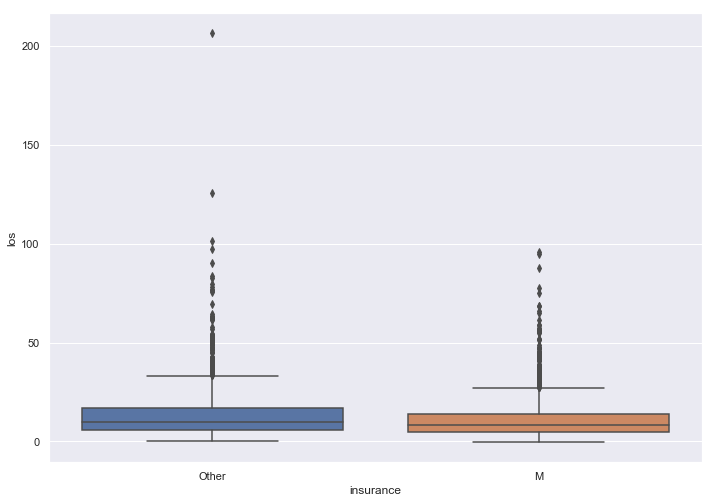

In [377]:
############
# INSURANCE BOXPLOTS
############

import seaborn as sns
import pandas as pd
from scipy import stats

sns.set(rc={'figure.figsize':(11.7,8.27)})

df = pd.read_csv('../data/exp/pneumonia-t3/first48hours.filtered.csv', header=0, index_col=0)
df.loc[df["insurance"] == "Medicaid", 'insurance'] = "Other"
df.loc[df["insurance"] == "Private", 'insurance'] = "Other"
df.loc[df["insurance"] == "Medicare", 'insurance'] = "M"
df.loc[df["insurance"] == "Government", 'insurance'] = "Other"
df.loc[df["insurance"] == "Self Pay", 'insurance'] = "Other"
ax = sns.boxplot(x="insurance", y="los", data=df)
alive = df[df["insurance"] == "M"]
dead = df[df["insurance"] == "Other"]
print(stats.ttest_ind(alive["los"], dead["los"], equal_var = False))


Ttest_indResult(statistic=-9.010174088101117, pvalue=1.1720378285549423e-18)


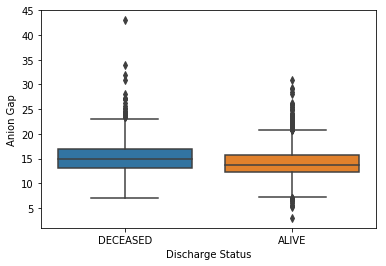

In [358]:
############
# BOXPLOTS
############

import seaborn as sns
import pandas as pd
from scipy import stats

df = pd.read_csv('../data/exp/pneumonia-t3/first48hours.filtered.csv', header=0, index_col=0)
df = df[df["Anion Gap"] > 0]
df["Discharge Status"] = df['status'].map({0: "ALIVE", 1: "DECEASED"})
ax = sns.boxplot(x="Discharge Status", y="Anion Gap", data=df)
alive = df[df["status"] == 0]
dead = df[df["status"] == 1]
print(stats.ttest_ind(alive["Anion Gap"], dead["Anion Gap"], equal_var = False))



---

### Explore feature selection on the patient outcomes (alive vs expired)
Because patient outcomes is a categorical feature, we will use a random forest classifier instead


In [30]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score

# Consider imputing the data with values other than zero
df = pd.read_csv('../data/exp/pneumonia-t3/first48hours.filtered.csv', header=0, index_col=0)
cols_to_one_hot = ['gender', 'insurance', 'language', 'religion', 'marital_status', 'ethnicity']
for col in cols_to_one_hot:
    one_hot = pd.get_dummies(df[col], col)
    df = df.drop(col, axis = 1)

df.pop('los')
status = df.pop('status')

# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)

# Train the classifier
clf.fit(df.values, status)

output = [a for a in zip(df.columns, clf.feature_importances_)]
output.sort(key=lambda pair: pair[1], reverse=True)

    

('age', 0.01725622901397037)
('Anion Gap', 0.013609254916032237)
('Anion Gap-trend', 0.01067699118504217)
('Atypical Lymphocytes', 0.004218491764975727)
('Bands', 0.0036866295350160305)
('Bands-trend', 0.0028609267899217953)
('Basophils', 0.005352590917996986)
('Basophils-trend', 0.0029317526182293576)
('Bicarbonate', 0.009836861192150905)
('Bicarbonate-trend', 0.014470115740924761)
('Chloride', 0.008511451492248176)
('Chloride-trend', 0.009011910852419095)
('Creatinine', 0.009413717194439406)
('Creatinine-trend', 0.008158519598329871)
('Eosinophils', 0.0055616286371694915)
('Eosinophils-trend', 0.003727803381335306)
('Glucose', 0.00790662189114697)
('Glucose-trend', 0.009028482570725764)
('Hematocrit', 0.008405622714473053)
('Hematocrit-trend', 0.009593518994937126)
('Hemoglobin', 0.008512119415287692)
('Hemoglobin-trend', 0.008429278656246902)
('INR(PT)', 0.008718071135572401)
('INR(PT)-trend', 0.006570296603242871)
('Lymphocytes', 0.009775762409445584)
('Lymphocytes-trend', 0.004598

### PCA 
Based on the features selected, generate PCA and explore variance for different populations

In [336]:
### Try PCA
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler

# Consider imputing the data with values other than zero
raw_dataset = pd.read_csv('../data/exp/pneumonia-t3/first48hours.filtered.csv', header=0)
df = raw_dataset.copy()

#df = df.loc[:, (df==0).mean() < .7]
#df.fillna(0, inplace=True)
#df = df.replace([np.inf, -np.inf], 0)

# Remove rows where the chartevents aren't available
df = df[df['Systolic'] > 0]
df = df[df['Anion Gap'] > 0]
df = df[df['Heart Rate'] > 0]
df = df[df['age'] >= 18]

cols_to_one_hot = ['language', 'religion', 'marital_status', 'ethnicity']
for col in cols_to_one_hot:
    one_hot = pd.get_dummies(df[col], col)
    df = df.drop(col, axis = 1)
    #df = df.join(one_hot)

status = df.pop('status')
insurance = df.pop('insurance')
gender = df.pop('gender')

#
# Normalize the dataset
#
train_stats = df.describe()
train_stats = train_stats.transpose()
scaled_features = StandardScaler().fit_transform(df.values)
df = pd.DataFrame(scaled_features, index=df.index, columns=df.columns)

# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)
# Train the classifier
clf.fit(df.values, status)
output = [a for a in zip(df.columns, clf.feature_importances_)]
output.sort(key=lambda pair: pair[1], reverse=True)


['los', 'Systolic', 'Diastolic', 'age', 'Anion Gap']
Features size:  5
shape of X_pca (3692, 3)
[0.37354349 0.33720139 0.28925512]


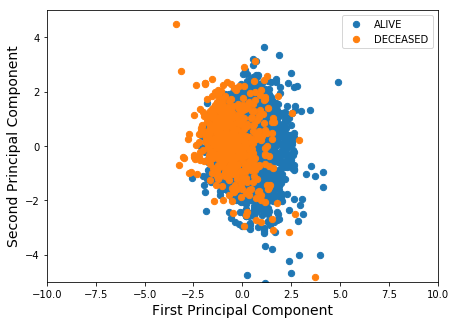

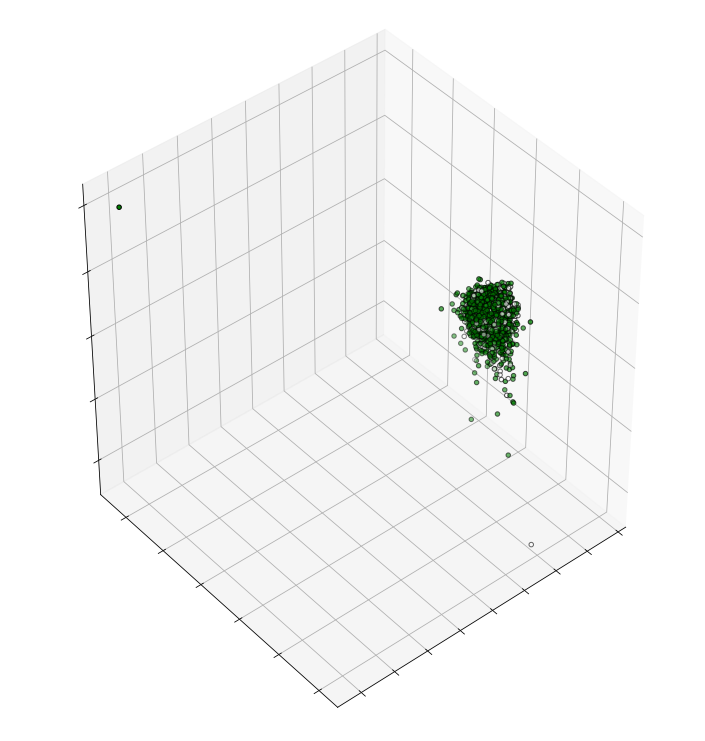

In [344]:

from mpl_toolkits.mplot3d import Axes3D

features_to_keep = []
for i in range(min(5, len(output))):
    features_to_keep.append(output[i][0])
print(features_to_keep)

print("Features size: ", len(features_to_keep))

X = df[features_to_keep].values
pca=PCA(n_components=3)
pca.fit(X)
X_pca=pca.transform(X) 

print("shape of X_pca", X_pca.shape)

ex_variance=np.var(X_pca,axis=0)
ex_variance_ratio = ex_variance/np.sum(ex_variance)
print(ex_variance_ratio)

Xax=X_pca[:,0]
Yax=X_pca[:,1]
labels=status
cdict={False:'red',True:'green'}
labl={False:'ALIVE',True:'DECEASED'}
marker={False:'*',True:'o'}
alpha={False:0.3, True:0.3}
fig,ax=plt.subplots(figsize=(7,5))
fig.patch.set_facecolor('white')
for l in np.unique(labels):
 ix=np.where(labels==l)
 ax.scatter(Xax[ix],Yax[ix],s=40,label=labl[l])
plt.xlabel("First Principal Component",fontsize=14)
plt.ylabel("Second Principal Component",fontsize=14)
plt.axis([-10, 10, -5, 5])
plt.legend()
plt.show()


###


fig = plt.figure(1, figsize=(10, 10))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=220, azim=130)

plt.cla()

# Reorder the labels to have colors matching the cluster results
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=status, cmap=plt.get_cmap('ocean'),
           edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

plt.show()